In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
from openpyxl import Workbook
import trino
from getpass import getpass
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, average_precision_score
from sklearn.datasets import load_wine
import optuna
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import shap
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *
import imp
import sys
from pyspark import SparkConf

In [31]:
dsn = cx_Oracle.makedsn("fbdwhrpd-scan", 1521, service_name="FBDWHPRD")
dsn = """(DESCRIPTION = (ADDRESS = (PROTOCOL = TCP) (HOST = fbdwhprd-scan) (PORT = 1521) ) (CONNECT_DATA = (SERVER = dedicated) (SERVICE_NAME = FBDWHPRD)))"""

connection = cx_Oracle.connect("FB007798", "PASSWORD", dsn,encoding = "UTF-8", nencoding = "UTF-8")

In [ ]:
AT_X_train =pd.read_sql("""(SELECT * FROM
(SELECT * FROM FB007798.BORSA_FINAL_TRAIN_3
WHERE TARGET = 1 AND AS_OF_DATE < to_date('20230630', 'YYYYMMDD'))
UNION ALL 
SELECT * FROM
(SELECT * FROM FB007798.BORSA_FINAL_TRAIN_3
ORDER BY DBMS_RANDOM.RANDOM) WHERE TARGET = 0 AND AS_OF_DATE < to_date('20230630', 'YYYYMMDD') AND rownum < 250000)""",connection)
AT_X_train.to_pickle('./AT_X_train.pickle')

In [4]:
AT_X_Test =pd.read_sql("""SELECT * FROM FB007798.BORSA_FINAL_TRAIN_3
WHERE AS_OF_DATE = to_date('20230630', 'YYYYMMDD')""",connection)
AT_X_Test.to_pickle('./AT_X_Test.pickle')

In [21]:
AT_X_train = pd.read_pickle('./AT_X_train.pickle')
AT_X_test = pd.read_pickle('./AT_X_Test.pickle')

In [ ]:
## X_TRAIN COUNTLY BEGINNING

In [ ]:
conn = trino.dbapi.connect(
    host= 'starburst.fibabanka.local',
    port= 443,
    http_scheme= 'https', 
    auth = trino.auth.BasicAuthentication('FB007798', 'PASSWORD'),
    verify='./cacert.pem'
    )
cur = conn.cursor()

In [ ]:
def connect(dbName):
    
    if dbName=='Trino':
        host= 'starburst.fibabanka.local'
        port=443
        http_scheme='https'
        verify='cacert.pem'
        username='FB007798'
        passwd='ŞİFRE'
        conn_info ={
            'host':host,
            'port':port,
            'user':username,
            'http_scheme':http_scheme,
            'verify':verify,
            'auth':trino.auth.BasicAuthentication(username,passwd)
        }
        connection=trino.dbapi.connect(**conn_info)
    
    else:
        raise ValueError("Invalid dbName provided")
    return connection

In [ ]:
connection = connect(dbName='Trino')

sql_file_path = 'countly_entegrasyonu.sql'

with open(sql_file_path,'r') as sql_file:
    query=sql_file.read()


cursor=connection.cursor()
cursor.execute(query)

AT_X_train = AT_X_train.set_index(['CUSTOMER_NUMBER', 'AS_OF_DATE'])

while True:
    data = pd.DataFrame(cursor.fetchmany(50000), columns=[desc[0] for desc in cursor.description])
    if len(data) == 0:
        break
    
    data['freq_lm_ratio'] = data['freq_lm'] / data['freq_l2m']
    data['as_of_date'] = pd.to_datetime(data['as_of_date'])
    
    data = data.drop_duplicates(subset=['customernumber', 'as_of_date', 'category', 'subcategory'])
    data = pd.pivot(data, index=['customernumber', 'as_of_date'], columns=['category', 'subcategory'], values=['freq_l2m', 'freq_lm', 'freq_lm_ratio'])
    data.columns = ['_'.join(col) for col in data.columns]
    
  #  print(data) 

    
    idxTrain = data[data.index.isin(AT_X_train.index)].index
    
    train_missing_cols = data.columns[~data.columns.isin(AT_X_train.columns)]
    AT_X_train[train_missing_cols] = np.nan
    
    AT_X_train.loc[idxTrain, data.columns] = data.loc[idxTrain, data.columns]
    print(len(data))

connection.close()

In [ ]:
AT_X_train.reset_index(inplace=True)

In [ ]:
## X_TRAIN COUNTLY ENDING

In [ ]:
## X_TEST COUNTLY BEGINNING

In [ ]:
HiveSQL ="select distinct ch.as_of_date,ch.customernumber, cl.category,cl.subcategory,ch.view_freq_last_2months as freq_l2m, ch.view_freq_last_month as freq_lm from countly.category_view_rank_history ch inner join countly.view_category_lookup cl on ch.category_code =cl.category_code where cl.category in('Yatırım-Hazine','Mevduat','Daily Banking') and cl.subcategory in('Kiraz','Kripto','Bes','Bono','FX','Oyak','Midas','Vadeli Mevduat','Fon','Şans Oyunu') -- and ch.as_of_date>=date_sub(to_date('20220631'),395) and ch.as_of_date>=date_add('day', -430, current_timestamp(1)) and ch.as_of_date=last_day_of_month(ch.as_of_date)"

In [ ]:
conf = SparkConf()  # create the configuration
conf.set("spark.jars", "/opt/cloudera/parcels/ORACLE_INSTANT_CLIENT/instantclient_11_2/ojdbc6.jar")

In [ ]:
spark = SparkSession.builder.appName("isim"). \
        enableHiveSupport().config("hive.exec.dynamic.partition", "true"). \
        config('spark.executor.memory','12g'). \
        config('spark.driver.memory','10g') .\
        config('spark.executor.instances',2) .\
        config('spark.kryoserializer.buffer.max',2040) .\
        config("spark.rpc.message.maxSize", "1000") .\
        config('spark.executor.cores',4) .\
        config(conf=conf). \
        getOrCreate()

In [ ]:
DF = spark.sql(HiveSQL)

In [ ]:
import databricks.koalas as koalas

In [ ]:
DF = DF.to_koalas()

In [ ]:
X_test_Countly = DF[(DF["as_of_date"] == "2023-06-30")]

In [ ]:
X = X_test_Countly.to_pandas()

In [ ]:
X = X.set_index(['customernumber', 'as_of_date'])

In [ ]:
X['freq_lm_ratio'] = X['freq_lm'] / X['freq_l2m']
X['as_of_date'] = pd.to_datetime(X['as_of_date'])
    
X = X.drop_duplicates(subset=['customernumber', 'as_of_date', 'category', 'subcategory'])
X = pd.pivot(X, index=['customernumber', 'as_of_date'], columns=['category', 'subcategory'], values=['freq_l2m', 'freq_lm', 'freq_lm_ratio'])
X.columns = ['_'.join(col) for col in X.columns]

In [ ]:
AT_X_test = AT_X_test.set_index(['CUSTOMER_NUMBER', 'AS_OF_DATE'])

In [ ]:
idxTest = X[X.index.isin(AT_X_test.index)].index
test_missing_cols = X.columns[~X.columns.isin(NT_X_test.columns)]
AT_X_test[test_missing_cols] = np.nan
AT_X_test.loc[idxTest, X.columns] = X.loc[idxTest, X.columns]

In [ ]:
AT_X_test.reset_index(inplace=True)

In [ ]:
## X_TEST COUNTLY ENDING

In [3]:
AT_X_train.index = AT_X_train["CUSTOMER_NUMBER"].astype(str) + AT_X_train["AS_OF_DATE"].astype(str)
AT_X_test.index = AT_X_test["CUSTOMER_NUMBER"].astype(str) + AT_X_test["AS_OF_DATE"].astype(str)

In [4]:
AT_X_train = AT_X_train.drop(["CUSTOMER_NUMBER", "CUSTOMER_ID"], axis = 1)
AT_X_test = AT_X_test.drop(["CUSTOMER_NUMBER", "CUSTOMER_ID"], axis = 1)

In [5]:
AT_Y_train = AT_X_train["TARGET"]
AT_Y_test = AT_X_test["TARGET"]

In [6]:
AT_X_valid = AT_X_train[AT_X_train["AS_OF_DATE"] == "2023-05-31"]
AT_Y_valid = AT_Y_train.loc[AT_X_valid.index]
AT_X_train = AT_X_train[AT_X_train["AS_OF_DATE"] < "2023-05-31"]
AT_Y_train = AT_Y_train.loc[AT_X_train.index]

In [7]:
AT_X_train = AT_X_train.drop("TARGET", axis=1)
AT_X_test = AT_X_test.drop("TARGET", axis=1)
AT_X_valid = AT_X_valid.drop("TARGET", axis=1)

In [8]:
AT_X_train["KKBSKORU"] = pd.to_numeric(AT_X_train["KKBSKORU"], downcast="float")
AT_X_train["BBEINDEX"] = pd.to_numeric(AT_X_train["BBEINDEX"], downcast="float")

AT_X_test["KKBSKORU"] = pd.to_numeric(AT_X_test["KKBSKORU"], downcast="float")
AT_X_test["BBEINDEX"] = pd.to_numeric(AT_X_test["BBEINDEX"], downcast="float")

AT_X_valid["KKBSKORU"] = pd.to_numeric(AT_X_valid["KKBSKORU"], downcast="float")
AT_X_valid["BBEINDEX"] = pd.to_numeric(AT_X_valid["BBEINDEX"], downcast="float")

In [11]:
AT_X_train.drop('CREDIT_CARD_LAST_TRANSACTION_DATE', axis=1, inplace=True)
AT_X_test.drop('CREDIT_CARD_LAST_TRANSACTION_DATE', axis=1, inplace=True)
AT_X_valid.drop('CREDIT_CARD_LAST_TRANSACTION_DATE', axis=1, inplace=True)

In [12]:
AT_X_train[AT_X_train == "Bilinmiyor"] = np.NaN
AT_X_train[AT_X_train == "None"] = np.NaN

AT_X_test[AT_X_test == "Bilinmiyor"] = np.NaN
AT_X_test[AT_X_test == "None"] = np.NaN

AT_X_valid[AT_X_valid == "Bilinmiyor"] = np.NaN
AT_X_valid[AT_X_valid == "None"] = np.NaN

In [13]:
fold_train = pd.DataFrame(AT_X_train["AS_OF_DATE"].unique()).sort_values(by = 0).reset_index().reset_index()
fold_train.drop("index", axis = 1, inplace = True)
fold_train = fold_train.rename(columns={'level_0': 'INDEX', 0: 'AS_OF_DATE'})

fold_test = pd.DataFrame(AT_X_test["AS_OF_DATE"].unique()).sort_values(by = 0).reset_index().reset_index()
fold_test.drop("index", axis = 1, inplace = True)
fold_test = fold_test.rename(columns={'level_0': 'INDEX', 0: 'AS_OF_DATE'})

fold_test['INDEX'] += (len(fold_train) + 1)

In [14]:
AT_X_train['AS_OF_DATE'] = AT_X_train['AS_OF_DATE'].map(fold_train.set_index('AS_OF_DATE')['INDEX'])
AT_X_test['AS_OF_DATE'] = AT_X_test['AS_OF_DATE'].map(fold_test.set_index('AS_OF_DATE')['INDEX'])

In [15]:
fold_valid = pd.DataFrame(AT_X_valid["AS_OF_DATE"].unique()).sort_values(by = 0).reset_index().reset_index()
fold_valid.drop("index", axis = 1, inplace = True)
fold_valid = fold_valid.rename(columns={'level_0': 'INDEX', 0: 'AS_OF_DATE'})

fold_valid['INDEX'] += len(fold_train)

In [16]:
AT_X_valid['AS_OF_DATE'] = AT_X_valid['AS_OF_DATE'].map(fold_valid.set_index('AS_OF_DATE')['INDEX'])

In [17]:
BIST_Verileri = pd.read_excel("./EVDS.xlsx", engine = "openpyxl")
BIST_Verileri = BIST_Verileri.drop(labels=[0,1,2,3,16], axis=0)
BIST_Verileri.rename(columns={"TP MK F BILESIK": "KapanisFiyati", "TP MK ISL HC": "Hacim", "TP MK ISL MK": "Miktar"}, inplace = True)
BIST_Verileri["KapanisFiyatiChange"] = BIST_Verileri["KapanisFiyati"].pct_change()
BIST_Verileri["HacimChange"] = BIST_Verileri["Hacim"].pct_change()
BIST_Verileri["MiktarChange"] = BIST_Verileri["Miktar"].pct_change()
fold_BIST = pd.DataFrame(BIST_Verileri["Tarih"].unique()).sort_values(by = 0).reset_index().reset_index()
fold_BIST.drop("index", axis = 1, inplace = True)
fold_BIST = fold_BIST.rename(columns={'level_0': 'INDEX', 0: 'Tarih'})
BIST_Verileri['Tarih'] = BIST_Verileri['Tarih'].map(fold_BIST.set_index('Tarih')['INDEX'])
BIST_Verileri

,Tarih,KapanisFiyati,Hacim,Miktar,KapanisFiyatiChange,HacimChange,MiktarChange
4,0,2592.38,6.397460e+11,6.591951e+10,NaN,NaN,NaN
5,1,3171.21,1.577050e+12,1.612720e+11,0.223281,1.465119,1.446499
6,2,3179.99,2.063060e+12,1.732010e+11,0.002769,0.308177,0.073968
7,3,3978.96,1.849730e+12,1.421840e+11,0.251249,-0.103405,-0.179081
8,4,4977.64,2.899310e+12,1.905200e+11,0.250990,0.567423,0.339954
9,5,5509.16,3.108830e+12,1.722420e+11,0.106782,0.072265,-0.095937
10,6,4976.55,2.791510e+12,1.329440e+11,-0.096677,-0.102071,-0.228156
11,7,5237.33,1.357090e+12,6.744557e+10,0.052402,-0.513851,-0.492677
12,8,4812.93,2.313710e+12,1.232830e+11,-0.081034,0.704905,0.827889
13,9,4617.93,1.267000e+12,6.724873e+10,-0.040516,-0.452395,-0.454517


In [18]:
x = (pd.merge(AT_X_train, BIST_Verileri, left_on='AS_OF_DATE', right_on='Tarih', how='left'))
x.index = AT_X_train.index
AT_X_train = x.drop("Tarih", axis=1)

In [19]:
y = (pd.merge(AT_X_test, BIST_Verileri, left_on='AS_OF_DATE', right_on='Tarih', how='left'))
y.index = AT_X_test.index
AT_X_test = y.drop("Tarih", axis=1)

In [20]:
z = (pd.merge(AT_X_valid, BIST_Verileri, left_on='AS_OF_DATE', right_on='Tarih', how='left'))
z.index = AT_X_valid.index
AT_X_valid = z.drop("Tarih", axis=1)

In [21]:
FHacim = pd.DataFrame(AT_X_train.groupby("AS_OF_DATE")["ALL_CNL_STOCK_SUM_VOLUME_L1M"].sum())
FHacim.reset_index(inplace=True)
FHacim.rename(columns={"AS_OF_DATE": "Tarih", "ALL_CNL_STOCK_SUM_VOLUME_L1M": "FibaHacimAylık"}, inplace = True)
FHacim["FibaHacimAylıkChange"] = FHacim["FibaHacimAylık"].pct_change()

x = (pd.merge(AT_X_train, FHacim, left_on='AS_OF_DATE', right_on='Tarih', how='left'))
x.index = AT_X_train.index
AT_X_train = x.drop("Tarih", axis=1)

FMiktar = pd.DataFrame(AT_X_train.groupby("AS_OF_DATE")["ALL_CNL_STOCK_STOCK_TXN_COUNT_L1M"].sum())
FMiktar.reset_index(inplace=True)
FMiktar.rename(columns={"AS_OF_DATE": "Tarih", "ALL_CNL_STOCK_STOCK_TXN_COUNT_L1M": "FibaMiktarAylık"}, inplace = True)
FMiktar["FibaMiktarAylıkChange"] = FMiktar["FibaMiktarAylık"].pct_change()

y = (pd.merge(AT_X_train, FMiktar, left_on='AS_OF_DATE', right_on='Tarih', how='left'))
y.index = AT_X_train.index
AT_X_train = y.drop("Tarih", axis=1)

In [22]:
FHacim9 = FHacim.loc[FHacim["Tarih"] == 9]
FMiktar9 = FMiktar.loc[FMiktar["Tarih"] == 9]

In [23]:
FHacim = pd.DataFrame(AT_X_valid.groupby("AS_OF_DATE")["ALL_CNL_STOCK_SUM_VOLUME_L1M"].sum())
FHacim.reset_index(inplace=True)
FHacim.rename(columns={"AS_OF_DATE": "Tarih", "ALL_CNL_STOCK_SUM_VOLUME_L1M": "FibaHacimAylık"}, inplace = True)
frames = [FHacim9, FHacim]
FHacim = pd.concat(frames)
FHacim["FibaHacimAylıkChange"] = FHacim["FibaHacimAylık"].pct_change()
FHacim = FHacim.drop(labels=[9], axis=0)

x = (pd.merge(AT_X_valid, FHacim, left_on='AS_OF_DATE', right_on='Tarih', how='left'))
x.index = AT_X_valid.index
AT_X_valid = x.drop("Tarih", axis=1)

FMiktar = pd.DataFrame(AT_X_valid.groupby("AS_OF_DATE")["ALL_CNL_STOCK_STOCK_TXN_COUNT_L1M"].sum())
FMiktar.reset_index(inplace=True)
FMiktar.rename(columns={"AS_OF_DATE": "Tarih", "ALL_CNL_STOCK_STOCK_TXN_COUNT_L1M": "FibaMiktarAylık"}, inplace = True)
frames = [FMiktar9, FMiktar]
FMiktar = pd.concat(frames)
FMiktar["FibaMiktarAylıkChange"] = FMiktar["FibaMiktarAylık"].pct_change()
FMiktar = FMiktar.drop(labels=[9], axis=0)

y = (pd.merge(AT_X_valid, FMiktar, left_on='AS_OF_DATE', right_on='Tarih', how='left'))
y.index = AT_X_valid.index
AT_X_valid = y.drop("Tarih", axis=1)

In [24]:
FHacim10 = FHacim.drop("FibaHacimAylıkChange", axis=1)
FMiktar10 = FMiktar.drop("FibaMiktarAylıkChange", axis=1)

In [25]:
FHacim = pd.DataFrame(AT_X_test.groupby("AS_OF_DATE")["ALL_CNL_STOCK_SUM_VOLUME_L1M"].sum())
FHacim.reset_index(inplace=True)
FHacim.rename(columns={"AS_OF_DATE": "Tarih", "ALL_CNL_STOCK_SUM_VOLUME_L1M": "FibaHacimAylık"}, inplace = True)
frames = [FHacim10, FHacim]
FHacim = pd.concat(frames)
FHacim["FibaHacimAylıkChange"] = FHacim["FibaHacimAylık"].pct_change()
FHacim = FHacim.reset_index(drop=True)
FHacim = FHacim.drop(labels=[0], axis=0)

x = (pd.merge(AT_X_test, FHacim, left_on='AS_OF_DATE', right_on='Tarih', how='left'))
x.index = AT_X_test.index
AT_X_test = x.drop("Tarih", axis=1)

FMiktar = pd.DataFrame(AT_X_test.groupby("AS_OF_DATE")["ALL_CNL_STOCK_STOCK_TXN_COUNT_L1M"].sum())
FMiktar.reset_index(inplace=True)
FMiktar.rename(columns={"AS_OF_DATE": "Tarih", "ALL_CNL_STOCK_STOCK_TXN_COUNT_L1M": "FibaMiktarAylık"}, inplace = True)
frames = [FMiktar10, FMiktar]
FMiktar = pd.concat(frames)
FMiktar["FibaMiktarAylıkChange"] = FMiktar["FibaMiktarAylık"].pct_change()
FMiktar = FMiktar.reset_index(drop=True)
FMiktar = FMiktar.drop(labels=[0], axis=0)

y = (pd.merge(AT_X_test, FMiktar, left_on='AS_OF_DATE', right_on='Tarih', how='left'))
y.index = AT_X_test.index
AT_X_test = y.drop("Tarih", axis=1)

In [26]:
AT_X_train["Fiba/Turkey_Hacim"] = AT_X_train["FibaHacimAylık"] / AT_X_train["Hacim"]
AT_X_train["Fiba/Turkey_Miktar"] = AT_X_train["FibaMiktarAylık"] / AT_X_train["Miktar"]

AT_X_test["Fiba/Turkey_Hacim"] = AT_X_test["FibaHacimAylık"] / AT_X_test["Hacim"]
AT_X_test["Fiba/Turkey_Miktar"] = AT_X_test["FibaMiktarAylık"] / AT_X_test["Miktar"]

AT_X_valid["Fiba/Turkey_Hacim"] = AT_X_valid["FibaHacimAylık"] / AT_X_valid["Hacim"]
AT_X_valid["Fiba/Turkey_Miktar"] = AT_X_valid["FibaMiktarAylık"] / AT_X_valid["Miktar"]

In [32]:
i = 0
while i < len(AT_X_train_categorical.columns):
    number = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
    AT_X_train_categorical.iloc[:,i] = number.fit_transform(AT_X_train_categorical.iloc[:,i].values.reshape(-1,1))
    AT_X_test_categorical.iloc[:,i]  = number.transform(AT_X_test_categorical.iloc[:,i].values.reshape(-1,1))
    AT_X_valid_categorical.iloc[:,i] = number.transform(AT_X_valid_categorical.iloc[:,i].values.reshape(-1,1))
    i += 1

In [33]:
AT_X_train = AT_X_train.drop(["CUSTOMER_LIFECYCLE_CURRENT", "CUSTOMER_LIFECYCLE_EVER", "FX_LIFECYCLE_CURRENT", "MESLEK_EDUCATION",  "MESLEK_WORK_STATUS", "MESLEK_OCCUPATION", "MESLEK_PROFESSION"], axis=1)
AT_X_test = AT_X_test.drop(["CUSTOMER_LIFECYCLE_CURRENT", "CUSTOMER_LIFECYCLE_EVER", "FX_LIFECYCLE_CURRENT", "MESLEK_EDUCATION",  "MESLEK_WORK_STATUS", "MESLEK_OCCUPATION", "MESLEK_PROFESSION"], axis=1)
AT_X_valid = AT_X_valid.drop(["CUSTOMER_LIFECYCLE_CURRENT", "CUSTOMER_LIFECYCLE_EVER", "FX_LIFECYCLE_CURRENT", "MESLEK_EDUCATION",  "MESLEK_WORK_STATUS", "MESLEK_OCCUPATION", "MESLEK_PROFESSION"], axis=1)

In [34]:
frames = [AT_X_train, AT_X_train_categorical]
AT_X_train = pd.concat(frames, axis="columns")

In [35]:
frames = [AT_X_test, AT_X_test_categorical]
AT_X_test = pd.concat(frames, axis="columns")

In [36]:
frames = [AT_X_valid, AT_X_valid_categorical]
AT_X_valid = pd.concat(frames, axis="columns")

In [41]:
## Improvement 
def filling_missing_values(col1, col2, col3):
        if (col1.median() > (col1.mean() - (0.5)*(col1.std()))) & (col1.median() < (col1.mean() + (0.5)*(col1.std()))):
            col3.fillna(col1.mean(), inplace = True)
            col2.fillna(col1.mean(), inplace = True)
            col1.fillna(col1.mean(), inplace = True)
        else:
            col3.fillna(col1.median(), inplace = True)
            col2.fillna(col1.median(), inplace = True)
            col1.fillna(col1.median(), inplace = True)

In [42]:
turn = 0
for col in list(AT_X_train.columns):
    filling_missing_values(AT_X_train[col], AT_X_test[col], AT_X_valid[col])
    turn += 1

In [51]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params, n_jobs = 8)
    optuna_model.fit(AT_X_train, AT_Y_train)

    # Make predictions
    # Y_pred_train = optuna_model.predict(NT_X_train)
    Y_pred_valid = optuna_model.predict(AT_X_valid)

    # Evaluate predictions
    # f1_train = f1_score(NT_Y_train, Y_pred_train, average='macro')
    f1 = f1_score(AT_Y_valid, Y_pred_valid, average='macro')
    # accuracy = accuracy_score(NT_Y_valid, Y_pred_valid)
    return f1 #, accuracy 
    #, (f1_train-f1_valid)

In [52]:
study = optuna.create_study(direction = 'maximize', study_name='Classifier')

[I 2023-07-29 15:51:47,966] A new study created in memory with name: Classifier


In [53]:
study.optimize(objective, n_trials=20, show_progress_bar=True)

  5%|▌         | 1/20 [00:29<09:13, 29.13s/it]

[I 2023-07-29 15:52:17,560] Trial 0 finished with value: 0.9430552445204499 and parameters: {'max_depth': 7, 'learning_rate': 0.026351360314430354, 'n_estimators': 148, 'min_child_weight': 5, 'gamma': 2.0635435833208472e-08, 'subsample': 0.5929066435441106, 'colsample_bytree': 0.037072994392624486, 'reg_alpha': 8.724907475497637e-07, 'reg_lambda': 0.012885804463603562}. Best is trial 0 with value: 0.9430552445204499.


 10%|█         | 2/20 [00:42<05:58, 19.94s/it]

[I 2023-07-29 15:52:31,060] Trial 1 finished with value: 0.9403260747193081 and parameters: {'max_depth': 7, 'learning_rate': 0.0683243659883685, 'n_estimators': 112, 'min_child_weight': 10, 'gamma': 0.03930300324784637, 'subsample': 0.03542790556107501, 'colsample_bytree': 0.011696414363137352, 'reg_alpha': 1.2254644865963922e-07, 'reg_lambda': 1.6347313570494772e-06}. Best is trial 0 with value: 0.9430552445204499.


 15%|█▌        | 3/20 [01:05<05:58, 21.10s/it]

[I 2023-07-29 15:52:53,553] Trial 2 finished with value: 0.9313494185455111 and parameters: {'max_depth': 4, 'learning_rate': 0.9369007398698375, 'n_estimators': 76, 'min_child_weight': 2, 'gamma': 6.034625877814126e-07, 'subsample': 0.01389366824693545, 'colsample_bytree': 0.6376805932050662, 'reg_alpha': 0.00427096779674914, 'reg_lambda': 1.4620883541090918e-07}. Best is trial 0 with value: 0.9430552445204499.


 20%|██        | 4/20 [01:54<08:38, 32.39s/it]

[I 2023-07-29 15:53:43,244] Trial 3 finished with value: 0.9627735779445976 and parameters: {'max_depth': 4, 'learning_rate': 0.026442226461044636, 'n_estimators': 169, 'min_child_weight': 8, 'gamma': 0.004729714556302386, 'subsample': 0.31270134958808404, 'colsample_bytree': 0.3702560883383744, 'reg_alpha': 0.0003993113369294674, 'reg_lambda': 2.1258006868005183e-07}. Best is trial 3 with value: 0.9627735779445976.


 25%|██▌       | 5/20 [02:06<06:15, 25.04s/it]

[I 2023-07-29 15:53:55,245] Trial 4 finished with value: 0.9554981808525056 and parameters: {'max_depth': 5, 'learning_rate': 0.44423406501531537, 'n_estimators': 74, 'min_child_weight': 9, 'gamma': 0.03018080553622051, 'subsample': 0.030593416047095316, 'colsample_bytree': 0.07474105947668, 'reg_alpha': 0.009346244411613436, 'reg_lambda': 1.56947435745845e-07}. Best is trial 3 with value: 0.9627735779445976.


 30%|███       | 6/20 [02:23<05:12, 22.31s/it]

[I 2023-07-29 15:54:12,274] Trial 5 finished with value: 0.9470766807295191 and parameters: {'max_depth': 8, 'learning_rate': 0.4319177474377114, 'n_estimators': 162, 'min_child_weight': 8, 'gamma': 0.0024864552258750845, 'subsample': 0.04007887087359502, 'colsample_bytree': 0.01312748642759781, 'reg_alpha': 1.087922316680651e-07, 'reg_lambda': 2.734266094720352e-07}. Best is trial 3 with value: 0.9627735779445976.


 35%|███▌      | 7/20 [03:25<07:39, 35.33s/it]

[I 2023-07-29 15:55:14,403] Trial 6 finished with value: 0.9624560417646398 and parameters: {'max_depth': 4, 'learning_rate': 0.042976505134627654, 'n_estimators': 196, 'min_child_weight': 7, 'gamma': 0.010433885904336908, 'subsample': 0.030008300368673496, 'colsample_bytree': 0.7934151920296656, 'reg_alpha': 0.36770098389753175, 'reg_lambda': 3.683067005419044e-05}. Best is trial 3 with value: 0.9627735779445976.


 40%|████      | 8/20 [04:36<09:20, 46.67s/it]

[I 2023-07-29 15:56:25,343] Trial 7 finished with value: 0.9639246316713483 and parameters: {'max_depth': 7, 'learning_rate': 0.22852788024166984, 'n_estimators': 195, 'min_child_weight': 6, 'gamma': 0.006406682189041974, 'subsample': 0.42647713585702873, 'colsample_bytree': 0.23088594562800246, 'reg_alpha': 8.9123517547569e-05, 'reg_lambda': 0.0002174343821899444}. Best is trial 7 with value: 0.9639246316713483.


 45%|████▌     | 9/20 [05:01<07:19, 39.91s/it]

[I 2023-07-29 15:56:50,392] Trial 8 finished with value: 0.9606611494608956 and parameters: {'max_depth': 9, 'learning_rate': 0.05010063774731311, 'n_estimators': 57, 'min_child_weight': 2, 'gamma': 0.004385196888089359, 'subsample': 0.11940964763977635, 'colsample_bytree': 0.283202233581972, 'reg_alpha': 2.5069701563720282e-05, 'reg_lambda': 1.558006002248523e-07}. Best is trial 7 with value: 0.9639246316713483.


 50%|█████     | 10/20 [06:08<08:00, 48.06s/it]

[I 2023-07-29 15:57:56,712] Trial 9 finished with value: 0.964755685094421 and parameters: {'max_depth': 7, 'learning_rate': 0.04792315935319239, 'n_estimators': 166, 'min_child_weight': 3, 'gamma': 0.009890233036480074, 'subsample': 0.19143909966083675, 'colsample_bytree': 0.3800313503082633, 'reg_alpha': 5.869500843986939e-05, 'reg_lambda': 4.002309577986125e-06}. Best is trial 9 with value: 0.964755685094421.


 55%|█████▌    | 11/20 [06:21<05:35, 37.33s/it]

[I 2023-07-29 15:58:09,708] Trial 10 finished with value: 0.906855059425587 and parameters: {'max_depth': 1, 'learning_rate': 0.01259207920066476, 'n_estimators': 127, 'min_child_weight': 3, 'gamma': 2.5296064203948432e-05, 'subsample': 0.16844470942667408, 'colsample_bytree': 0.10160246069295158, 'reg_alpha': 4.1076353207678545e-06, 'reg_lambda': 0.042334126051489396}. Best is trial 9 with value: 0.964755685094421.


 60%|██████    | 12/20 [07:13<05:35, 41.97s/it]

[I 2023-07-29 15:59:02,297] Trial 11 finished with value: 0.9645025061806034 and parameters: {'max_depth': 6, 'learning_rate': 0.17617156712192064, 'n_estimators': 199, 'min_child_weight': 5, 'gamma': 0.7158597609435526, 'subsample': 0.8240896386542672, 'colsample_bytree': 0.1860523214956411, 'reg_alpha': 0.00019472198668343393, 'reg_lambda': 0.0001185718432890018}. Best is trial 9 with value: 0.964755685094421.


 65%|██████▌   | 13/20 [07:52<04:46, 40.95s/it]

[I 2023-07-29 15:59:40,898] Trial 12 finished with value: 0.9645869194863192 and parameters: {'max_depth': 6, 'learning_rate': 0.16244084797997876, 'n_estimators': 182, 'min_child_weight': 4, 'gamma': 0.46741388387934457, 'subsample': 0.9807743636040742, 'colsample_bytree': 0.1380769154555329, 'reg_alpha': 0.0016601702109962893, 'reg_lambda': 4.826684116765224e-05}. Best is trial 9 with value: 0.964755685094421.


 70%|███████   | 14/20 [08:35<04:09, 41.51s/it]

[I 2023-07-29 16:00:23,694] Trial 13 finished with value: 0.9626971346827096 and parameters: {'max_depth': 9, 'learning_rate': 0.1209904959341132, 'n_estimators': 174, 'min_child_weight': 4, 'gamma': 0.8215485385375461, 'subsample': 0.2484314854622552, 'colsample_bytree': 0.11172121977793775, 'reg_alpha': 0.005678682278059038, 'reg_lambda': 8.913269018403868e-06}. Best is trial 9 with value: 0.964755685094421.


 75%|███████▌  | 15/20 [08:53<02:52, 34.43s/it]

[I 2023-07-29 16:00:41,724] Trial 14 finished with value: 0.9515351679716748 and parameters: {'max_depth': 6, 'learning_rate': 0.09277615734504822, 'n_estimators': 145, 'min_child_weight': 1, 'gamma': 0.0001102309698946031, 'subsample': 0.06133377337977442, 'colsample_bytree': 0.04442459262383502, 'reg_alpha': 0.3682990240893192, 'reg_lambda': 0.0019062270917712208}. Best is trial 9 with value: 0.964755685094421.


 80%|████████  | 16/20 [09:25<02:15, 33.77s/it]

[I 2023-07-29 16:01:13,974] Trial 15 finished with value: 0.9642575073154216 and parameters: {'max_depth': 3, 'learning_rate': 0.26733271339569054, 'n_estimators': 116, 'min_child_weight': 4, 'gamma': 0.00013262227564593378, 'subsample': 0.9389512764375031, 'colsample_bytree': 0.45581935278739755, 'reg_alpha': 0.0010049607336641028, 'reg_lambda': 0.5194767812273983}. Best is trial 9 with value: 0.964755685094421.


 85%|████████▌ | 17/20 [10:00<01:42, 34.15s/it]

[I 2023-07-29 16:01:49,004] Trial 16 finished with value: 0.9485982721584773 and parameters: {'max_depth': 6, 'learning_rate': 0.010730378753231832, 'n_estimators': 179, 'min_child_weight': 3, 'gamma': 0.24573956088976093, 'subsample': 0.20478123676487375, 'colsample_bytree': 0.13793512719062387, 'reg_alpha': 0.03804350985277411, 'reg_lambda': 5.288388572543671e-06}. Best is trial 9 with value: 0.964755685094421.


 90%|█████████ | 18/20 [10:58<01:22, 41.31s/it]

[I 2023-07-29 16:02:46,967] Trial 17 finished with value: 0.9595026816003587 and parameters: {'max_depth': 2, 'learning_rate': 0.026323085645706557, 'n_estimators': 144, 'min_child_weight': 1, 'gamma': 0.0992087604973537, 'subsample': 0.4599998760095123, 'colsample_bytree': 0.9685820069592751, 'reg_alpha': 1.0860185240782047e-05, 'reg_lambda': 0.0011570874751152857}. Best is trial 9 with value: 0.964755685094421.


 95%|█████████▌| 19/20 [11:21<00:35, 35.81s/it]

[I 2023-07-29 16:03:09,959] Trial 18 finished with value: 0.9593535265929025 and parameters: {'max_depth': 8, 'learning_rate': 0.1406912996646843, 'n_estimators': 158, 'min_child_weight': 6, 'gamma': 0.0006171975168749605, 'subsample': 0.07812536194101027, 'colsample_bytree': 0.05467657984158565, 'reg_alpha': 2.1266530987635534e-06, 'reg_lambda': 2.130275029706664e-05}. Best is trial 9 with value: 0.964755685094421.


100%|██████████| 20/20 [11:37<00:00, 34.87s/it]

[I 2023-07-29 16:03:25,856] Trial 19 finished with value: 0.946143475378891 and parameters: {'max_depth': 5, 'learning_rate': 0.07836682101500457, 'n_estimators': 134, 'min_child_weight': 4, 'gamma': 5.5629048636818896e-06, 'subsample': 0.14647203919435023, 'colsample_bytree': 0.028763249506415338, 'reg_alpha': 1.886671460748577e-08, 'reg_lambda': 1.7343829099895859e-06}. Best is trial 9 with value: 0.964755685094421.


In [54]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.964755685094421
  Params: 
    max_depth: 7
    learning_rate: 0.04792315935319239
    n_estimators: 166
    min_child_weight: 3
    gamma: 0.009890233036480074
    subsample: 0.19143909966083675
    colsample_bytree: 0.3800313503082633
    reg_alpha: 5.869500843986939e-05
    reg_lambda: 4.002309577986125e-06


In [57]:
params = trial.params

In [58]:
AT_XGB_Model = XGBClassifier(**params, n_jobs = 8)
AT_XGB_Model.fit(AT_X_train, AT_Y_train)

[19:44:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3800313503082633,
              enable_categorical=False, gamma=0.009890233036480074, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.04792315935319239, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=166, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=5.869500843986939e-05,
              reg_lambda=4.002309577986125e-06, scale_pos_weight=1,
              subsample=0.19143909966083675, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [60]:
AT_XGB_Model.save_model("AT_XGB_Model.json")

In [55]:
AT_X_test1 = AT_X_test.iloc[:800000,:]
AT_X_test1.to_pickle('./AT_X_test1.pickle')
AT_X_test2 = AT_X_test.iloc[800000:1600000,:]
AT_X_test2.to_pickle('./AT_X_test2.pickle')
AT_X_test3 = AT_X_test.iloc[1600000:2400000,:]
AT_X_test3.to_pickle('./AT_X_test3.pickle')
AT_X_test4 = AT_X_test.iloc[2400000:,:]
AT_X_test4.to_pickle('./AT_X_test4.pickle')

OSError: [Errno 122] Disk quota exceeded

In [61]:
Y_Prediction1 = pd.DataFrame(AT_XGB_Model.predict_proba(AT_X_test1), index = AT_X_test1.index, columns = ["0", "1"])
Y_Prediction2 = pd.DataFrame(AT_XGB_Model.predict_proba(AT_X_test2), index = AT_X_test2.index, columns = ["0", "1"])
Y_Prediction3 = pd.DataFrame(AT_XGB_Model.predict_proba(AT_X_test3), index = AT_X_test3.index, columns = ["0", "1"])
Y_Prediction4 = pd.DataFrame(AT_XGB_Model.predict_proba(AT_X_test4), index = AT_X_test4.index, columns = ["0", "1"])

In [62]:
AT_Y_Prediction = pd.concat([Y_Prediction1, Y_Prediction2, Y_Prediction3, Y_Prediction4], axis = 0)

In [63]:
AT_Y_Prediction["TARGET"] = AT_Y_test
AT_Y_Prediction = AT_Y_Prediction.sort_values(by = "1", ascending = False)

In [64]:
AT_Y_Prediction.to_pickle('./AT_Y_Prediction.pickle')

In [68]:
def custcounter(sorted_actual):
    sorted_actual['FXDURUMU'] = sorted_actual['TARGET']
    ratio = sorted_actual[sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/sorted_actual.shape[0]
    print('---------------------------------')
    print('Total customer count:' , sorted_actual.shape[0])
    print('Total BORSA Users:' , sorted_actual[sorted_actual['FXDURUMU']==1]['FXDURUMU'].count() )
    print('Total ratio:', ratio)
    print('---------------------------------')
    print('First 1000 customers: {}, The Lift Ratio of First 1000 customers: {}, Correct Number of Preds: {}'.format(sorted_actual[:1000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/1000, sorted_actual[:1000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/1000/ratio, sorted_actual[:1000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()))
    print('First 5k customers: {}, The Lift Ratio of First 5k customers: {}, Correct Number of Preds: {}'.format(sorted_actual[:5000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/5000, sorted_actual[:5000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/5000/ratio, sorted_actual[:5000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()))
    print('First 10k customers: {}, The Lift Ratio of First 10k customers: {}, Correct Number of Preds: {}'.format(sorted_actual[:10000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/10000, sorted_actual[:10000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/10000/ratio, sorted_actual[:10000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()))
    print('First 20k customers: {}, The Lift Ratio of First 20k customers: {}, Correct Number of Preds: {}'.format(sorted_actual[:20000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/20000, sorted_actual[:20000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/20000/ratio, sorted_actual[:20000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()))
    print('First 25k customers: {}, The Lift Ratio of First 25k customers: {}, Correct Number of Preds: {}'.format(sorted_actual[:25000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/25000, sorted_actual[:25000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/25000/ratio, sorted_actual[:25000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()))
    print('First 30k customers: {}, The Lift Ratio of First 30k customers: {}, Correct Number of Preds: {}'.format(sorted_actual[:30000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/30000, sorted_actual[:30000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/30000/ratio, sorted_actual[:30000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()))
    print('First 40k customers: {}, The Lift Ratio of First 40k customers: {}, Correct Number of Preds: {}'.format(sorted_actual[:40000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/40000, sorted_actual[:40000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/40000/ratio, sorted_actual[:40000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()))
    print('First 50k customers: {}, The Lift Ratio of First 50k customers: {}, Correct Number of Preds: {}'.format(sorted_actual[:50000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/50000, sorted_actual[:50000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/50000/ratio, sorted_actual[:50000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()))
    print('First 500k customers: {}, The Lift Ratio of First 500k customers: {}, Correct Number of Preds: {}'.format(sorted_actual[:500000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/500000, sorted_actual[:500000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()*100/500000/ratio, sorted_actual[:500000][sorted_actual['FXDURUMU']==1]['FXDURUMU'].count()))    

In [66]:
def probbincounter(sortedpreds, y_test):
    print('---------------------------------')
    # print("Above 90th percent of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[sortedpreds>.90]), int((y_pairs[pair][1].reindex(list(sortedpreds[sortedpreds>.90].index))==1).sum())))

    if len(sortedpreds[(sortedpreds>.90)&(sortedpreds<=1)])>0:
        print("Between 90th and 100th prob. of Predictions: {}, Compared to Actual Transactions: {}, Accuracy out of 100: {}".format(len(sortedpreds[(sortedpreds>.90)&(sortedpreds<=1)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.90)&(sortedpreds<=1)].index))==1).sum()), 100*(int((y_test.reindex(list(sortedpreds[(sortedpreds>.90)&(sortedpreds<=1)].index))==1).sum())) / (len(sortedpreds[(sortedpreds>.90)&(sortedpreds<=1)])) ))
    else:
        print("Between 90th and 100th prob. of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[(sortedpreds>.90)&(sortedpreds<=1)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.90)&(sortedpreds<=1)].index))==1).sum())))
  
    
    if len(sortedpreds[(sortedpreds>.80)&(sortedpreds<=.90)])>0:
        print("Between 80th and 90th prob. of Predictions: {}, Compared to Actual Transactions: {}, Accuracy out of 100: {}".format(len(sortedpreds[(sortedpreds>.80)&(sortedpreds<=.90)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.80)&(sortedpreds<=.90)].index))==1).sum()), 100*(int((y_test.reindex(list(sortedpreds[(sortedpreds>.80)&(sortedpreds<=.90)].index))==1).sum())) / (len(sortedpreds[(sortedpreds>.80)&(sortedpreds<=.90)])) ))
    else:
        print("Between 80th and 90th prob. of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[(sortedpreds>.80)&(sortedpreds<=.90)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.80)&(sortedpreds<=.90)].index))==1).sum())))
    
    if len(sortedpreds[(sortedpreds>.70)&(sortedpreds<=.80)])>0:    
        print("Between 70th and 80th prob. of Predictions: {}, Compared to Actual Transactions: {}, Accuracy out of 100: {}".format(len(sortedpreds[(sortedpreds>.70)&(sortedpreds<=.80)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.70)&(sortedpreds<=.80)].index))==1).sum()), 100*(int((y_test.reindex(list(sortedpreds[(sortedpreds>.70)&(sortedpreds<=.80)].index))==1).sum())) / (len(sortedpreds[(sortedpreds>.70)&(sortedpreds<=.80)]))))
    else:
        print("Between 70th and 80th prob. of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[(sortedpreds>.70)&(sortedpreds<=.80)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.70)&(sortedpreds<=.80)].index))==1).sum())))
    
    if len(sortedpreds[(sortedpreds>.60)&(sortedpreds<=.70)])>0:    
        print("Between 60th and 70th prob. of Predictions: {}, Compared to Actual Transactions: {}, Accuracy out of 100: {}".format(len(sortedpreds[(sortedpreds>.60)&(sortedpreds<=.70)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.60)&(sortedpreds<=.70)].index))==1).sum()), 100*(int((y_test.reindex(list(sortedpreds[(sortedpreds>.60)&(sortedpreds<=.70)].index))==1).sum())) / (len(sortedpreds[(sortedpreds>.60)&(sortedpreds<=.70)]))))
    else:
        print("Between 60th and 70th prob. of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[(sortedpreds>.60)&(sortedpreds<=.70)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.60)&(sortedpreds<=.70)].index))==1).sum())))
    
    if len(sortedpreds[(sortedpreds>.50)&(sortedpreds<=.60)])>0: 
        print("Between 50th and 60th prob. of Predictions: {}, Compared to Actual Transactions: {}, Accuracy out of 100: {}".format(len(sortedpreds[(sortedpreds>.50)&(sortedpreds<=.60)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.50)&(sortedpreds<=.60)].index))==1).sum()), 100*(int((y_test.reindex(list(sortedpreds[(sortedpreds>.50)&(sortedpreds<=.60)].index))==1).sum())) / (len(sortedpreds[(sortedpreds>.50)&(sortedpreds<=.60)]))))
    else:
        print("Between 50th and 60th prob. of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[(sortedpreds>.50)&(sortedpreds<=.60)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.50)&(sortedpreds<=.60)].index))==1).sum())))
        
    if len(sortedpreds[(sortedpreds>.40)&(sortedpreds<=.50)])>0: 
        print("Between 40th and 50th prob. of Predictions: {}, Compared to Actual Transactions: {}, Accuracy out of 100: {}".format(len(sortedpreds[(sortedpreds>.40)&(sortedpreds<=.50)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.40)&(sortedpreds<=.50)].index))==1).sum()), 100*(int((y_test.reindex(list(sortedpreds[(sortedpreds>.40)&(sortedpreds<=.50)].index))==1).sum())) / (len(sortedpreds[(sortedpreds>.40)&(sortedpreds<=.50)]))))
    else:
        print("Between 40th and 50th prob. of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[(sortedpreds>.40)&(sortedpreds<=.50)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.40)&(sortedpreds<=.50)].index))==1).sum())))

    if len(sortedpreds[(sortedpreds>.30)&(sortedpreds<=.40)])>0:     
        print("Between 30th and 40th prob. of Predictions: {}, Compared to Actual Transactions: {}, Accuracy out of 100: {}".format(len(sortedpreds[(sortedpreds>.30)&(sortedpreds<=.40)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.30)&(sortedpreds<=.40)].index))==1).sum()), 100*(int((y_test.reindex(list(sortedpreds[(sortedpreds>.30)&(sortedpreds<=.40)].index))==1).sum())) / (len(sortedpreds[(sortedpreds>.30)&(sortedpreds<=.40)]))))
    else:
        print("Between 30th and 40th prob. of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[(sortedpreds>.30)&(sortedpreds<=.40)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.30)&(sortedpreds<=.40)].index))==1).sum())))
        
    if len(sortedpreds[(sortedpreds>.20)&(sortedpreds<=.30)])>0: 
        print("Between 20th and 30th prob. of Predictions: {}, Compared to Actual Transactions: {}, Accuracy out of 100: {}".format(len(sortedpreds[(sortedpreds>.20)&(sortedpreds<=.30)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.20)&(sortedpreds<=.30)].index))==1).sum()), 100*(int((y_test.reindex(list(sortedpreds[(sortedpreds>.20)&(sortedpreds<=.30)].index))==1).sum())) / (len(sortedpreds[(sortedpreds>.20)&(sortedpreds<=.30)]))))
    else:
        print("Between 20th and 30th prob. of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[(sortedpreds>.20)&(sortedpreds<=.30)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>.20)&(sortedpreds<=.30)].index))==1).sum())))
        
    if len(sortedpreds[(sortedpreds>.10)&(sortedpreds<=.20)])>0:
        print("Between 10th and 20th prob. of Predictions: {}, Compared to Actual Transactions: {}, Accuracy out of 100: {}".format(len(sortedpreds[ (sortedpreds>.10)&(sortedpreds<=.20)]), int((y_test.reindex(list(sortedpreds[(sortedpreds> .10)&(sortedpreds<=.20)].index))==1).sum()), 100*(int((y_test.reindex(list(sortedpreds[(sortedpreds> .10)&(sortedpreds<=.20)].index))==1).sum())) / (len(sortedpreds[(sortedpreds> .10)&(sortedpreds<=.20)]))))
    else:
        print("Between 10th and 20th prob. of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[ (sortedpreds>.10)&(sortedpreds<=.20)]), int((y_test.reindex(list(sortedpreds[(sortedpreds> .10)&(sortedpreds<=.20)].index))==1).sum())))
        
    if len(sortedpreds[(sortedpreds>.0)&(sortedpreds<=.10)])>0:    
        print("Between  0th and 10th prob. of Predictions: {}, Compared to Actual Transactions: {}, Accuracy out of 100: {}".format(len(sortedpreds[ (sortedpreds>=.0)&(sortedpreds<=.10)]), int((y_test.reindex(list(sortedpreds[(sortedpreds> .0)&(sortedpreds<=.10)].index))==1).sum()), 100*(int((y_test.reindex(list(sortedpreds[(sortedpreds>= .0)&(sortedpreds<=.10)].index))==1).sum())) / (len(sortedpreds[(sortedpreds>= .0)&(sortedpreds<=.10)]))))
    else:
        print("Between  0th and 10th prob. of Predictions: {}, Compared to Actual Transactions: {}".format(len(sortedpreds[ (sortedpreds>=.0)&(sortedpreds<=.10)]), int((y_test.reindex(list(sortedpreds[(sortedpreds>= .0)&(sortedpreds<=.10)].index))==1).sum())))    

In [69]:
custcounter(AT_Y_Prediction)

---------------------------------
Total customer count: 3133870
Total BORSA Users: 13709
Total ratio: 0.4374463522737063
---------------------------------
First 1000 customers: 96.4, The Lift Ratio of First 1000 customers: 220.36987964111168, Correct Number of Preds: 964
First 5k customers: 88.8, The Lift Ratio of First 5k customers: 202.9963206652564, Correct Number of Preds: 4440
First 10k customers: 75.81, The Lift Ratio of First 10k customers: 173.3012507841564, Correct Number of Preds: 7581
First 20k customers: 53.915, The Lift Ratio of First 20k customers: 123.24939897147858, Correct Number of Preds: 10783
First 25k customers: 45.716, The Lift Ratio of First 25k customers: 104.50652922897366, Correct Number of Preds: 11429
First 30k customers: 39.18666666666667, The Lift Ratio of First 30k customers: 89.58050847375203, Correct Number of Preds: 11756
First 40k customers: 30.2325, The Lift Ratio of First 40k customers: 69.11133180757167, Correct Number of Preds: 12093
First 50k cus

In [70]:
probbincounter(AT_Y_Prediction["1"], AT_Y_Prediction["TARGET"])

---------------------------------
Between 90th and 100th prob. of Predictions: 21366, Compared to Actual Transactions: 10990, Accuracy out of 100: 51.43686230459609
Between 80th and 90th prob. of Predictions: 7744, Compared to Actual Transactions: 727, Accuracy out of 100: 9.387913223140496
Between 70th and 80th prob. of Predictions: 8793, Compared to Actual Transactions: 324, Accuracy out of 100: 3.68474923234391
Between 60th and 70th prob. of Predictions: 10451, Compared to Actual Transactions: 217, Accuracy out of 100: 2.0763563295378433
Between 50th and 60th prob. of Predictions: 11989, Compared to Actual Transactions: 170, Accuracy out of 100: 1.4179664692634915
Between 40th and 50th prob. of Predictions: 14333, Compared to Actual Transactions: 168, Accuracy out of 100: 1.1721202818670202
Between 30th and 40th prob. of Predictions: 18622, Compared to Actual Transactions: 149, Accuracy out of 100: 0.8001288798195683
Between 20th and 30th prob. of Predictions: 27550, Compared to Act

In [2]:
AT_X_test1 = pd.read_pickle('./AT_X_test1.pickle')
AT_X_test2 = pd.read_pickle('./AT_X_test2.pickle')
AT_X_test3 = pd.read_pickle('./AT_X_test3.pickle')
AT_X_test4 = pd.read_pickle('./AT_X_test4.pickle')

In [4]:
AT_XGB_Model = xgb.XGBClassifier()
AT_XGB_Model.load_model("AT_XGB_Model.json")

In [5]:
explainer = shap.TreeExplainer(AT_XGB_Model)
shap_values = explainer.shap_values(AT_X_test1)

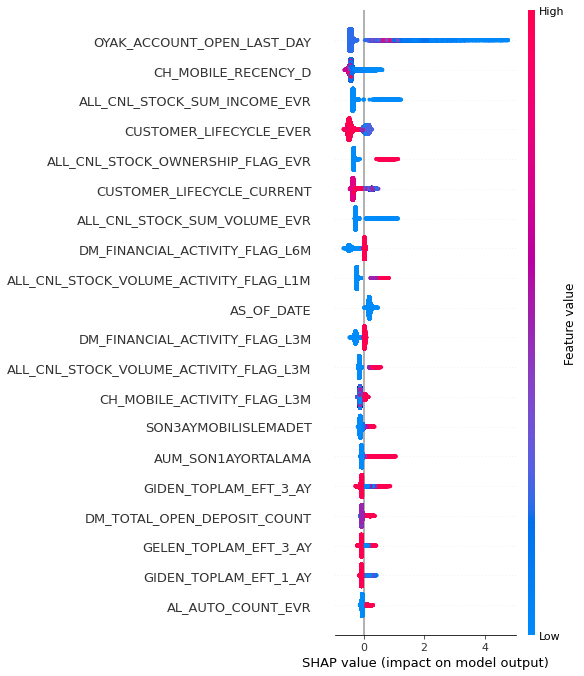

In [6]:
shap.summary_plot(shap_values, AT_X_test1)

In [11]:
AT_Y_Prediction = pd.read_pickle('./AT_Y_Prediction.pickle')

In [12]:
AT_Y_Prediction

,0,1,TARGET
61590682023-06-30,0.000565,0.999435,1
22317032023-06-30,0.000605,0.999395,1
59248792023-06-30,0.000626,0.999374,1
22420722023-06-30,0.000654,0.999346,1
49006832023-06-30,0.000734,0.999266,1
...,...,...,...
10735982023-06-30,0.999335,0.000665,0
25896422023-06-30,0.999336,0.000664,0
39129282023-06-30,0.999337,0.000663,0
31537912023-06-30,0.999339,0.000661,0


In [13]:
AT_Y_Prediction["PERC"] = AT_Y_Prediction["1"].rank(pct = True)

In [14]:
AT_Y_Prediction.reset_index(inplace = True)

In [15]:
AT_Y_Prediction.columns = ["CUSTOMER", "ZEROS", "ONES", "TARGET", "PERC"]

In [16]:
AT_Y_Prediction

,CUSTOMER,ZEROS,ONES,TARGET,PERC
0,61590682023-06-30,0.000565,0.999435,1,1.000000e+00
1,22317032023-06-30,0.000605,0.999395,1,9.999997e-01
2,59248792023-06-30,0.000626,0.999374,1,9.999994e-01
3,22420722023-06-30,0.000654,0.999346,1,9.999990e-01
4,49006832023-06-30,0.000734,0.999266,1,9.999987e-01
...,...,...,...,...,...
3133865,10735982023-06-30,0.999335,0.000665,0,1.595471e-06
3133866,25896422023-06-30,0.999336,0.000664,0,1.276377e-06
3133867,39129282023-06-30,0.999337,0.000663,0,9.572828e-07
3133868,31537912023-06-30,0.999339,0.000661,0,6.381886e-07


In [20]:
AT_Y_Prediction[(AT_Y_Prediction['PERC']>0.90) & (AT_Y_Prediction['TARGET']==1)]

,CUSTOMER,ZEROS,ONES,TARGET,PERC
0,61590682023-06-30,0.000565,0.999435,1,1.000000
1,22317032023-06-30,0.000605,0.999395,1,1.000000
2,59248792023-06-30,0.000626,0.999374,1,0.999999
3,22420722023-06-30,0.000654,0.999346,1,0.999999
4,49006832023-06-30,0.000734,0.999266,1,0.999999
...,...,...,...,...,...
303807,43902792023-06-30,0.958994,0.041006,1,0.903057
305293,43979082023-06-30,0.959299,0.040701,1,0.902583
309325,40798572023-06-30,0.960115,0.039885,1,0.901296
312061,47266032023-06-30,0.960637,0.039363,1,0.900423


In [37]:
print("Bireysel ve Potansiyel olmayan Müşteri Kitlemiz {} kişi. Borsa Yaptığını Tespit Ettiğimiz Müşteri Kitlemiz {} kişi.".format(AT_Y_Prediction.shape[0], AT_Y_Prediction[AT_Y_Prediction['TARGET']==1].shape[0]))
print('')
print("Kitlemizin % {} gittiğimizde, FibaBorsa'da işlem yapan ve FibaBorsa'da işlem yapmayıp başka Menkul Yatırım firmalarını para transferi gerçekleştirecek müşteri kitlemizin % {}'na ulaşabiliyoruz".format(AT_Y_Prediction[AT_Y_Prediction['PERC']>0.99].shape[0]/AT_Y_Prediction.shape[0]*100, (AT_Y_Prediction[(AT_Y_Prediction['PERC']>0.99) & (AT_Y_Prediction['TARGET']==1)].shape[0] / AT_Y_Prediction[AT_Y_Prediction['TARGET']==1].shape[0])*100))
print('')
print("Kitlemizin % {} gittiğimizde, FibaBorsa'da işlem yapan ve FibaBorsa'da işlem yapmayıp başka Menkul Yatırım firmalarını para transferi gerçekleştirecek müşteri kitlemizin % {}'na ulaşabiliyoruz".format(AT_Y_Prediction[AT_Y_Prediction['PERC']>0.95].shape[0]/AT_Y_Prediction.shape[0]*100, (AT_Y_Prediction[(AT_Y_Prediction['PERC']>0.95) & (AT_Y_Prediction['TARGET']==1)].shape[0] / AT_Y_Prediction[AT_Y_Prediction['TARGET']==1].shape[0])*100))
print('')
print("Kitlemizin % {} gittiğimizde, FibaBorsa'da işlem yapan ve FibaBorsa'da işlem yapmayıp başka Menkul Yatırım firmalarını para transferi gerçekleştirecek müşteri kitlemizin % {}'na ulaşabiliyoruz".format(AT_Y_Prediction[AT_Y_Prediction['PERC']>0.90].shape[0]/AT_Y_Prediction.shape[0]*100, (AT_Y_Prediction[(AT_Y_Prediction['PERC']>0.90) & (AT_Y_Prediction['TARGET']==1)].shape[0] / AT_Y_Prediction[AT_Y_Prediction['TARGET']==1].shape[0])*100))
print('')
print("Kitlemizin % {} gittiğimizde, FibaBorsa'da işlem yapan ve FibaBorsa'da işlem yapmayıp başka Menkul Yatırım firmalarını para transferi gerçekleştirecek müşteri kitlemizin % {}'na ulaşabiliyoruz".format(AT_Y_Prediction[AT_Y_Prediction['PERC']>0.80].shape[0]/AT_Y_Prediction.shape[0]*100, (AT_Y_Prediction[(AT_Y_Prediction['PERC']>0.80) & (AT_Y_Prediction['TARGET']==1)].shape[0] / AT_Y_Prediction[AT_Y_Prediction['TARGET']==1].shape[0])*100))
print('')
print("Kitlemizin % {} gittiğimizde, FibaBorsa'da işlem yapan ve FibaBorsa'da işlem yapmayıp başka Menkul Yatırım firmalarını para transferi gerçekleştirecek müşteri kitlemizin % {}'na ulaşabiliyoruz".format(AT_Y_Prediction[AT_Y_Prediction['PERC']>0.70].shape[0]/AT_Y_Prediction.shape[0]*100, (AT_Y_Prediction[(AT_Y_Prediction['PERC']>0.70) & (AT_Y_Prediction['TARGET']==1)].shape[0] / AT_Y_Prediction[AT_Y_Prediction['TARGET']==1].shape[0])*100))

Bireysel ve Potansiyel olmayan Müşteri Kitlemiz 3133870 kişi. Borsa Yaptığını Tespit Ettiğimiz Müşteri Kitlemiz 13709 kişi.

Kitlemizin % 1.0000095728284837 gittiğimizde, FibaBorsa'da işlem yapan ve FibaBorsa'da işlem yapmayıp başka Menkul Yatırım firmalarını para transferi gerçekleştirecek müşteri kitlemizin % 86.22802538478372'na ulaşabiliyoruz

Kitlemizin % 5.00001595471414 gittiğimizde, FibaBorsa'da işlem yapan ve FibaBorsa'da işlem yapmayıp başka Menkul Yatırım firmalarını para transferi gerçekleştirecek müşteri kitlemizin % 95.52119045882267'na ulaşabiliyoruz

Kitlemizin % 10.0 gittiğimizde, FibaBorsa'da işlem yapan ve FibaBorsa'da işlem yapmayıp başka Menkul Yatırım firmalarını para transferi gerçekleştirecek müşteri kitlemizin % 97.56364432124882'na ulaşabiliyoruz

Kitlemizin % 20.0 gittiğimizde, FibaBorsa'da işlem yapan ve FibaBorsa'da işlem yapmayıp başka Menkul Yatırım firmalarını para transferi gerçekleştirecek müşteri kitlemizin % 98.86935589758554'na ulaşabiliyoruz

Kitle